In [1]:
import pandas as pd
import numpy as np

### we'll forecast 2 - TS that might be affecting each-other using VAR.

> k = 2 as we're using 2 time series.

1. M2 Money Stock >>>
    how much money ppl have?
    
2. Personal Consumption from FRED >>>
    how much money people spend ?

> This is a 2-way interaction ie both affect each other, unlike exogenous var with a TV.


how they affect one another?<br>
if ppl spend more money they have less savings (2 affecting 1)<br>
if ppl have more savings they would have been spending less. (1 affecting 2)<br>

> USE 2-Dimensional VAR(p) model here. say :

1. y_1,t = money stock
2. y_2,t = personal consumption

<br>

<i> but what is 'p' ? </i><br>
* find by checking various p-values in a for - loop using best AIC.
* auto_arima grid search wont work

<i> why AIC? </i> <br>
* info criterion to compare multiple model fittings.
* punishes models for being complex, even if AIC is slightly better

> so as <B>p increases => AIC drops. then after certain lag (p's value) => AIC increases.</B> 
    THAT LAG IS OPTIMAL AIC.
    
<br>    
also, we need to MANUALLY 
1. check for stationarity
2. difference to make it stationary

coz there's no I term that will automatically difference, as this is simple VAR model.


> difference both series by same amount st THEY HAVE SAME NO. OF ROWS.

In [15]:
# warnings

import warnings
warnings.filterwarnings('ignore')


# default figsize

from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = (12,6)

In [5]:
# load datasets

ms = pd.read_csv('Data/M2SLMoneyStock.csv', index_col=0, parse_dates=True)
ms.index.freq='MS'

ps = pd.read_csv('Data/PCEPersonalSpending.csv', index_col=0, parse_dates=True)
ps.index.freq = 'MS'

In [6]:
# loading specific forecasting tools

from statsmodels.tsa.api import VAR

from statsmodels.tsa.stattools import adfuller

from statsmodels.tools.eval_measures import rmse

In [7]:
ms.head()

,Money
Date,
1995-01-01,3492.4
1995-02-01,3489.9
1995-03-01,3491.1
1995-04-01,3499.2
1995-05-01,3524.2


In [8]:
ps.head()

,Spending
Date,
1995-01-01,4851.2
1995-02-01,4850.8
1995-03-01,4885.4
1995-04-01,4890.2
1995-05-01,4933.1


In [9]:
# combining these into a single dataframe

# use pd.merge() or df.join()

df = ms.join(ps)

In [10]:
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


In [12]:
# dropping any null rows

df.dropna(axis=0, inplace=True)

In [14]:
df.shape

# 252 data values

(252, 2)

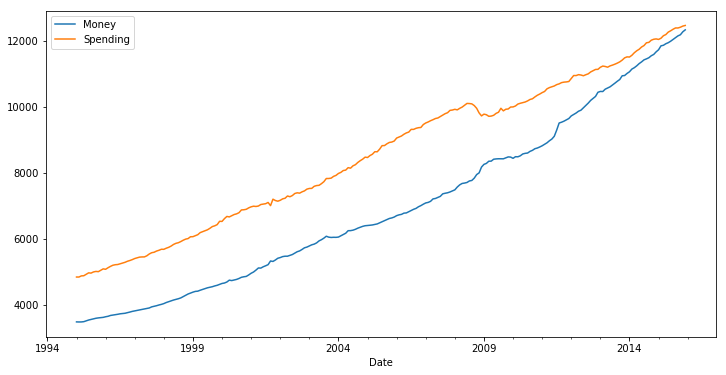

In [17]:
df.plot();

spending > money <BR>
but for recent years they seem to CONVERGE.

##### test for stationarity & necessary transformations

by transformations it means diff() dataset

In [20]:
# ADF test  - h0 = non stationary series

res1 = adfuller(df['Money'])

if(res1[1] < 0.05):
    print('Stationary')
    
else: 
    print('Non Stationary')

Non Stationary


In [21]:
res2 = adfuller(df['Spending'])

if(res1[1] < 0.05):
    print('Stationary')
    
else: 
    print('Non Stationary')

Non Stationary


> both the TS are non-stationary. so differencing is needed on both columns.

we've been importing diff from statsmodels.

but, 

> if you're dealing with an entire df, pandas has differencing 'method' for a dataframe.

In [23]:
# 1st order diff of entire dataframe 

df_1 = df.diff()

In [24]:
df_1.head(3)

,Money,Spending
Date,,
1995-01-01,NaN,NaN
1995-02-01,-2.5,-0.4
1995-03-01,1.2,34.6


In [26]:
# re-running adftest on df_1 ie differneced dataframe

res1 = adfuller(df_1['Money'].dropna(axis=0))

if(res1[1] < 0.05):
    print('Stationary')
    
else: 
    print('Non Stationary')

Non Stationary


In [28]:
res2 = adfuller(df_1['Spending'].dropna())

if(res2[1] < 0.05):
    print('Stationary')
    
else: 
    print('Non Stationary')

Stationary


so 'Spending' has become stationary, but 'Money' is still Non-stationary.

> APPLY 2ND ORDER TO DIFFERNECING to BOTH series. (Remember, equal no. of differencing has to be applied on both)

coz we need to have same no. of available rows in both the series to apply VAR. hence diff() same no. of times.

even if one of the series has become stationary already.

> later, we'll undo this differencing (twice here)

In [29]:
df_2 = df_1.diff()

In [31]:
df_2.head(3)

,Money,Spending
Date,,
1995-01-01,NaN,NaN
1995-02-01,NaN,NaN
1995-03-01,3.7,35.0


In [32]:
# check if 'money' is stationary now

res1 = adfuller(df_2['Money'].dropna())

if(res1[1] < 0.05):
    print('Stationary')
    
else: 
    print('Non Stationary')

Stationary


In [33]:
# YESSSSSSSSSSSSSSSSSSSSSSSSSSSSSS

In [34]:
res1 = adfuller(df_2['Spending'].dropna())

if(res1[1] < 0.05):
    print('Stationary')
    
else: 
    print('Non Stationary')

Stationary


both stationary now !!!!!!!!!!!!


## TRAIN TEST SPLIT & EVALUATION

In [36]:
# 12 months as test set to forecast 1 year into the future 

df_2.dropna(inplace=True)

train = df_2[: -12]  # negative indexing -12 = 12th term from right

test = df_2[-12 :]

In [37]:
len(test)

12

In [38]:
len(train)

238

## order of VAR -> perform GRIDSEARCH 

(for AR-component of VAR-model)

auto_arima doesnt work for this.

> for seasonal data, use p upto 1 season. max p = seasonal period

In [69]:
model = VAR(train)

l = [1,2,3,4,5,6,7]   # list of some p-order values to test
d = dict()

for p in l:
    
    #for each p , fit model, calc AIC, print them
    
    results = model.fit(p)
    
    d[p] = results.aic   # a dictionary for each p & its aic
    
    mini = results.aic
    
    print('order :', p)
    print('AIC : ', results.aic)
    print('\n')

order : 1
AIC :  14.178610495220896


order : 2
AIC :  13.955189367163705


order : 3
AIC :  13.849518291541038


order : 4
AIC :  13.827950574458283


order : 5
AIC :  13.78730034460964


order : 6
AIC :  13.799076756885809


order : 7
AIC :  13.797638727913972




In [70]:
for key in d:
    if(d[key] < mini):
        mini = d[key]
        k = key
        
print(mini, k , sep=" = ")

13.78730034460964 = 5


so AIC drops as we increase p, after p=5, it begins to increase. so p = 5 is our required optimal order.

In [71]:
# fitting VAR with order 5

final_results = model.fit(5)

In [72]:
final_results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 24, Aug, 2021
Time:                     03:22:42
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.1131
Nobs:                     233.000    HQIC:                   13.9187
Log likelihood:          -2245.45    FPE:                    972321.
AIC:                      13.7873    Det(Omega_mle):         886628.
--------------------------------------------------------------------
Results for equation Money
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.516683         1.782238            0.290           0.772
L1.Money           -0.646232         0.068177           -9.479           0.000
L1.Spending        -0.107411         0.051388           -2.090      


in the output we've 2 time series (k=2). and equations and results for both the time series.



## forecasting next 12 values